In [1]:
# First we need to get historical data
his_dir = "/annual/kl/historical/"
print("Subdirectory on FTP Server is ;", his_dir) # we are making sure we are getting right sub directory

Subdirectory on FTP Server is ; /annual/kl/historical/


In [2]:
#This part taken from notebook provided by notebook to us
#lclftp_dir         = "../data/original/DWD/"      # Local directory for input data, local data sources, or copies of local FTP data. 
lclftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies input 
iclftp_st_dir = lclftp_dir + his_dir # local station info 
local_ftp_ts_dir      = lclftp_dir + his_dir # Local directory where time series downloaded from FTP

#local_generated_dir   = "../data/generated/DWD/" # The generated of derived data in contrast to lclftp_dir
local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to lclftp_dir
local_station_dir     = local_generated_dir + his_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + his_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + his_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [3]:
import os #to interact directly with Jupyter Notebook
os.makedirs(lclftp_dir,exist_ok = True)
os.makedirs(iclftp_st_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

In [4]:
#To make sure that the desired directories were sucessful.
print(lclftp_dir) 
print(iclftp_st_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//annual/kl/historical/
data/original/DWD//annual/kl/historical/

data/generated/DWD/
data/generated/DWD//annual/kl/historical/
data/generated/DWD//annual/kl/historical/
data/generated/DWD//annual/kl/historical/


In [5]:
#The parameters for taking the data from the server, FTP(File Transfer Protocol) used for integrating
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

In [6]:
# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"

# The absolute ftp directory with the data (his_dir(historical data)) of concern, the one we derive the data for the purposes of this task
ftp_dir =  ftp_climate_data_dir + his_dir
print("FTP directory path with data of concern:", ftp_dir)

FTP directory path with data of concern: /climate_environment/CDC/observations_germany/climate//annual/kl/historical/


In [7]:
#FTP connection check
import ftplib # FTP protocol client, for the cliet side of FTP. Used for automated FTP jobs, like mirroring other FTP servers.
ftp = ftplib.FTP(server) 
res = ftp.login(user=user, passwd = passwd) #Credential check
print(res) #Result of FTP operation

230 Login successful.


In [8]:
ret = ftp.cwd(".") # to set current directory on server

In [9]:
#Getting files from a server
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")

In [10]:
#Generating Pandas Dataframe from FTP Directory (again from provided notebook)
import pandas as pd

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [11]:
# time sensivity code, has to be fun simultaneously after the FTP connection code
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir) #To generate data frame from FTP directories
df_ftpdir # the desired directories 

,station_id,name,ext,size,type
0,-1,KL_Jahreswerte_Beschreibung_Stationen.txt,.txt,1202611,-
1,1,jahreswerte_KL_00001_19310101_19860630_hist.zip,.zip,13239,-
2,3,jahreswerte_KL_00003_18510101_20110331_hist.zip,.zip,20305,-
3,44,jahreswerte_KL_00044_19710301_20221231_hist.zip,.zip,16405,-
4,52,jahreswerte_KL_00052_19730101_20011231_hist.zip,.zip,13960,-
...,...,...,...,...,...
1132,19579,jahreswerte_KL_19579_19710101_20051031_hist.zip,.zip,12376,-
1133,19580,jahreswerte_KL_19580_19750101_20051231_hist.zip,.zip,11935,-
1134,19581,jahreswerte_KL_19581_19740601_20050331_hist.zip,.zip,13132,-
1135,19582,jahreswerte_KL_19582_19460101_20001231_hist.zip,.zip,15345,-


In [12]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname) #Text file with the description of all the stations

KL_Jahreswerte_Beschreibung_Stationen.txt


In [13]:
# Gettting file from the server to the local directory
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + iclftp_st_dir + station_fname)
grabFile(ftp_dir + station_fname, iclftp_st_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//annual/kl/historical/KL_Jahreswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//annual/kl/historical/KL_Jahreswerte_Beschreibung_Stationen.txt


In [14]:
# Codecs are matters, for this case its the umlaut.

import codecs
def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile, "r", encoding="latin1")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
# Translate the descriptions in german to english    
    translate = \
    {'Stations_id':'Station_id',
     'von_datum':'Date_from',
     'bis_datum':'Date_to',
     'Stationshoehe':'Altitude',
     'geoBreite': 'Latitude',
     'geoLaenge': 'Longitude',
     'Stationsname':'Station_name',
     'Bundesland':'State'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    # Parse dates to make them more readable
    df = pd.read_fwf(\
        txtfile, skiprows=2, names=colnames_en, \
        parse_dates=["Date_from","Date_to"], index_col = 0, \
        encoding="latin1")
    
    # write csv file with ; as a seperator
    df.to_csv(csvfile, sep = ";")
    return(df)

In [15]:
#derive a data frame with all the stations
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(iclftp_st_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,Date_from,Date_to,Altitude,Latitude,Longitude,Station_name,State
Station_id,,,,,,,
1,1931-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
3,1851-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
44,1971-03-01,2023-12-31,44,52.9336,8.2370,Großenkneten,Niedersachsen
52,1973-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
61,1975-07-01,1978-08-31,339,48.8443,12.6171,Aiterhofen,Bayern


In [16]:
#values are true if they are desired
isNRW = (df_stations['State'] == "Nordrhein-Westfalen").values
isActive2022 = (df_stations['Date_to'] >= "2022").values 
isActive1950 = (df_stations['Date_from'] < "1950").values 
station_ids_selected = df_stations[isNRW & isActive2022 & isActive1950].index
print(f"Stations located in NRW, started before 1950 and still active in 2022 are: \n{list(station_ids_selected)}")

Stations located in NRW, started before 1950 and still active in 2022 are: 
[555, 1078, 1300, 1303, 1327, 1590, 2110, 2483, 2497, 2629, 2968, 4371, 5717]


In [17]:
#we are getting the dataframe
df_station_active = df_stations.loc[station_ids_selected].head(13)
df_station_active

,Date_from,Date_to,Altitude,Latitude,Longitude,Station_name,State
Station_id,,,,,,,
555,1925-01-01,2023-12-31,110,51.5026,7.2289,Bochum,Nordrhein-Westfalen
1078,1940-01-01,2023-12-31,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen
1300,1931-01-01,2023-12-31,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
1303,1888-01-01,2023-12-31,150,51.4041,6.9677,Essen-Bredeney,Nordrhein-Westfalen
1327,1937-01-01,2023-12-31,147,50.7119,6.7905,Weilerswist-Lommersum,Nordrhein-Westfalen
1590,1937-01-01,2023-12-31,37,51.4942,6.2463,Geldern-Walbeck,Nordrhein-Westfalen
2110,1938-01-01,2023-12-31,57,51.0411,6.1042,Heinsberg-Schleiden,Nordrhein-Westfalen
2483,1926-11-01,2023-12-31,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
2497,1937-01-01,2023-12-31,505,50.5014,6.5264,Kall-Sistig,Nordrhein-Westfalen


In [18]:
#Exporting the dataframe
df_station_active.to_csv('data/ActiveSationsNRW.csv')

In [19]:
#TASK 1.2 
#We already know there are 13 station 

In [20]:
import geopandas as gpd # for make it easier to assess geospatial data 
from osgeo import gdal # translator library for raster and vector geospatial data format
#we will use CSV file, however we could also use *df_station_active* dataframe
df = pd.read_csv('data/ActiveSationsNRW.csv')
# Load the CSV file into a pandas DataFrame and convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
crs = "EPSG:4326" # Coordinate reference system of the dataframe
gdf.crs = 'EPSG:4326' # Set the CRS of the GeoDataFrame
#exporting the geopackage for further work on QGIS
gdf.to_file(r'data/SelectedStations.gpkg', driver='GPKG', layer='SelectedStations')
gdf #geodataframe containing the descriptions of the selected stations

,Station_id,Date_from,Date_to,Altitude,Latitude,Longitude,Station_name,State,geometry
0,555,1925-01-01,2023-12-31,110,51.5026,7.2289,Bochum,Nordrhein-Westfalen,POINT (7.22890 51.50260)
1,1078,1940-01-01,2023-12-31,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen,POINT (6.76860 51.29600)
2,1300,1931-01-01,2023-12-31,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen,POINT (8.15650 51.25400)
3,1303,1888-01-01,2023-12-31,150,51.4041,6.9677,Essen-Bredeney,Nordrhein-Westfalen,POINT (6.96770 51.40410)
4,1327,1937-01-01,2023-12-31,147,50.7119,6.7905,Weilerswist-Lommersum,Nordrhein-Westfalen,POINT (6.79050 50.71190)
5,1590,1937-01-01,2023-12-31,37,51.4942,6.2463,Geldern-Walbeck,Nordrhein-Westfalen,POINT (6.24630 51.49420)
6,2110,1938-01-01,2023-12-31,57,51.0411,6.1042,Heinsberg-Schleiden,Nordrhein-Westfalen,POINT (6.10420 51.04110)
7,2483,1926-11-01,2023-12-31,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen,POINT (8.48910 51.18030)
8,2497,1937-01-01,2023-12-31,505,50.5014,6.5264,Kall-Sistig,Nordrhein-Westfalen,POINT (6.52640 50.50140)
9,2629,1851-01-01,2023-12-31,46,51.7612,6.0954,Kleve,Nordrhein-Westfalen,POINT (6.09540 51.76120)


In [21]:
#Task 1.3

In [22]:
# We will call all available files from the FTP server
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head()
# Local directory for the files that are going to be automatically downnloaded
data_path = r"data/original/DWD/annual/kl/historical/"

In [23]:
# Using defined function grabFile to automatically download the data for the selected stations
local_zip_list = []

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

jahreswerte_KL_00555_19250101_20221231_hist.zip
jahreswerte_KL_01078_19400101_20221231_hist.zip
jahreswerte_KL_01300_19310101_20221231_hist.zip
jahreswerte_KL_01303_18880101_20221231_hist.zip
jahreswerte_KL_01327_19370101_20221231_hist.zip
jahreswerte_KL_01590_19370101_20221231_hist.zip
jahreswerte_KL_02110_19380101_20221231_hist.zip
jahreswerte_KL_02483_19261101_20221231_hist.zip
jahreswerte_KL_02497_19370101_20221231_hist.zip
jahreswerte_KL_02629_18510101_20221231_hist.zip
jahreswerte_KL_02968_19030101_20221231_hist.zip
jahreswerte_KL_04371_19310101_20221231_hist.zip
jahreswerte_KL_05717_19070101_20221231_hist.zip


In [24]:
# List of the downloaded files for the selected stations from the server to the local directory
fname_list = os.listdir(data_path)
fname_list

['jahreswerte_KL_00555_19250101_20221231_hist.zip',
 'jahreswerte_KL_01078_19400101_20221231_hist.zip',
 'jahreswerte_KL_01300_19310101_20221231_hist.zip',
 'jahreswerte_KL_01303_18880101_20221231_hist.zip',
 'jahreswerte_KL_01327_19370101_20221231_hist.zip',
 'jahreswerte_KL_01590_19370101_20221231_hist.zip',
 'jahreswerte_KL_02110_19380101_20221231_hist.zip',
 'jahreswerte_KL_02483_19261101_20221231_hist.zip',
 'jahreswerte_KL_02497_19370101_20221231_hist.zip',
 'jahreswerte_KL_02629_18510101_20221231_hist.zip',
 'jahreswerte_KL_02968_19030101_20221231_hist.zip',
 'jahreswerte_KL_04371_19310101_20221231_hist.zip',
 'jahreswerte_KL_05717_19070101_20221231_hist.zip',
 'KL_Jahreswerte_Beschreibung_Stationen.txt']

In [25]:
# List of the downloaded zip files for the selected stations
local_zip_list 

['jahreswerte_KL_00555_19250101_20221231_hist.zip',
 'jahreswerte_KL_01078_19400101_20221231_hist.zip',
 'jahreswerte_KL_01300_19310101_20221231_hist.zip',
 'jahreswerte_KL_01303_18880101_20221231_hist.zip',
 'jahreswerte_KL_01327_19370101_20221231_hist.zip',
 'jahreswerte_KL_01590_19370101_20221231_hist.zip',
 'jahreswerte_KL_02110_19380101_20221231_hist.zip',
 'jahreswerte_KL_02483_19261101_20221231_hist.zip',
 'jahreswerte_KL_02497_19370101_20221231_hist.zip',
 'jahreswerte_KL_02629_18510101_20221231_hist.zip',
 'jahreswerte_KL_02968_19030101_20221231_hist.zip',
 'jahreswerte_KL_04371_19310101_20221231_hist.zip',
 'jahreswerte_KL_05717_19070101_20221231_hist.zip']

In [26]:
#Task 1.4

# We need to use seaborn for visuluation,based on matplotlib and pyplot to plot
import seaborn as sns
import matplotlib.pyplot as plt
fname_list = os.listdir(data_path)
fname_list

['jahreswerte_KL_00555_19250101_20221231_hist.zip',
 'jahreswerte_KL_01078_19400101_20221231_hist.zip',
 'jahreswerte_KL_01300_19310101_20221231_hist.zip',
 'jahreswerte_KL_01303_18880101_20221231_hist.zip',
 'jahreswerte_KL_01327_19370101_20221231_hist.zip',
 'jahreswerte_KL_01590_19370101_20221231_hist.zip',
 'jahreswerte_KL_02110_19380101_20221231_hist.zip',
 'jahreswerte_KL_02483_19261101_20221231_hist.zip',
 'jahreswerte_KL_02497_19370101_20221231_hist.zip',
 'jahreswerte_KL_02629_18510101_20221231_hist.zip',
 'jahreswerte_KL_02968_19030101_20221231_hist.zip',
 'jahreswerte_KL_04371_19310101_20221231_hist.zip',
 'jahreswerte_KL_05717_19070101_20221231_hist.zip',
 'KL_Jahreswerte_Beschreibung_Stationen.txt']

In [27]:
#we are converting the files
f_dict={}

for fname in fname_list:
    try:
        key=fname.split("_")[2]
        f_dict[int(key)]=fname
    except:
        print(f"Cannot convert \'{key:s}\' to integer")

n=5
print("Frist {n:d} items of f_dict:")
print({k: f_dict[k] for k in list(f_dict)[:5]})


Cannot convert 'Beschreibung' to integer
Frist {n:d} items of f_dict:
{555: 'jahreswerte_KL_00555_19250101_20221231_hist.zip', 1078: 'jahreswerte_KL_01078_19400101_20221231_hist.zip', 1300: 'jahreswerte_KL_01300_19310101_20221231_hist.zip', 1303: 'jahreswerte_KL_01303_18880101_20221231_hist.zip', 1327: 'jahreswerte_KL_01327_19370101_20221231_hist.zip'}


In [28]:
# Zip list for all 13 selected stations
zip_list=[]
for k in df_station_active.index:
    zip_list.append(data_path + f_dict[k])
zip_list

['data/original/DWD/annual/kl/historical/jahreswerte_KL_00555_19250101_20221231_hist.zip',
 'data/original/DWD/annual/kl/historical/jahreswerte_KL_01078_19400101_20221231_hist.zip',
 'data/original/DWD/annual/kl/historical/jahreswerte_KL_01300_19310101_20221231_hist.zip',
 'data/original/DWD/annual/kl/historical/jahreswerte_KL_01303_18880101_20221231_hist.zip',
 'data/original/DWD/annual/kl/historical/jahreswerte_KL_01327_19370101_20221231_hist.zip',
 'data/original/DWD/annual/kl/historical/jahreswerte_KL_01590_19370101_20221231_hist.zip',
 'data/original/DWD/annual/kl/historical/jahreswerte_KL_02110_19380101_20221231_hist.zip',
 'data/original/DWD/annual/kl/historical/jahreswerte_KL_02483_19261101_20221231_hist.zip',
 'data/original/DWD/annual/kl/historical/jahreswerte_KL_02497_19370101_20221231_hist.zip',
 'data/original/DWD/annual/kl/historical/jahreswerte_KL_02629_18510101_20221231_hist.zip',
 'data/original/DWD/annual/kl/historical/jahreswerte_KL_02968_19030101_20221231_hist.zip',

In [34]:
from zipfile import ZipFile

# Creating a data frame
df_SelectedStations = pd.DataFrame()
for elt in zip_list:
    with ZipFile(elt) as myzip:
        
        # read individual time series data starting with 'produkt'
        prodfilename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0] 
       
        # open just the produkt file within the archive
        with myzip.open(prodfilename) as myfile:
            dftmp = pd.read_csv(myfile, sep =";", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], index_col = "MESS_DATUM_BEGINN", na_values = [-999.0])
            # Select the series with the average annual temp ("JA_TT"), rename the series with the station_id and make it a df.
            s = dftmp["JA_TT"].rename(dftmp["STATIONS_ID"][0]).to_frame()
            # right merge the data for inclusivity of all the date between 1851 and 2022
            df_SelectedStations = pd.merge(df_SelectedStations, s, left_index=True, right_index=True, how='right')
            df_SelectedStations.index.rename(name = "year", inplace = True)
df_SelectedStations


,555,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4371,5717
year,,,,,,,,,,,,,
1907-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.29
1908-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.72
1909-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.42
1910-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.63
1911-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.67,11.05,NaN
2019-01-01,NaN,11.84,9.00,11.44,11.24,11.62,11.42,7.00,9.27,11.17,12.30,10.89,10.99
2020-01-01,NaN,12.25,9.44,11.84,11.81,12.18,12.06,7.28,9.70,11.63,12.84,11.00,11.45


In [35]:
# Replace full datetime as integer, extract year from index as integer
df_SelectedStations.set_index(df_SelectedStations.index.year, inplace= True)

df_SelectedStations.head()

,555,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4371,5717
year,,,,,,,,,,,,,
1907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.29
1908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.72
1909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.42
1910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.63
1911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.29


In [36]:
# Avarage tempature formula
AverageTemp = df_SelectedStations[(df_SelectedStations.index >= 1950) & (df_SelectedStations.index <= 2022)].mean()
AverageTemp

555     10.463684
1078    10.685854
1300     7.843208
1303    10.004912
1327    10.120702
1590    10.395962
2110    10.296731
2483     5.302951
2497     7.684308
2629     9.950448
2968    11.158169
4371     9.526986
5717     9.758472
dtype: float64

In [37]:
#Our new deviated tempature dataframe
df_temp_diff = (df_SelectedStations - AverageTemp)
df_temp_diff

,555,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4371,5717
year,,,,,,,,,,,,,
1907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.468472
1908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.038472
1909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.338472
1910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.128472
1911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.531528
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.511831,1.523014,NaN
2019,NaN,1.154146,1.156792,1.435088,1.119298,1.224038,1.123269,1.697049,1.585692,1.219552,1.141831,1.363014,1.231528
2020,NaN,1.564146,1.596792,1.835088,1.689298,1.784038,1.763269,1.977049,2.015692,1.679552,1.681831,1.473014,1.691528


Text(333.08333333333337, 0.5, 'Selected station numbers')

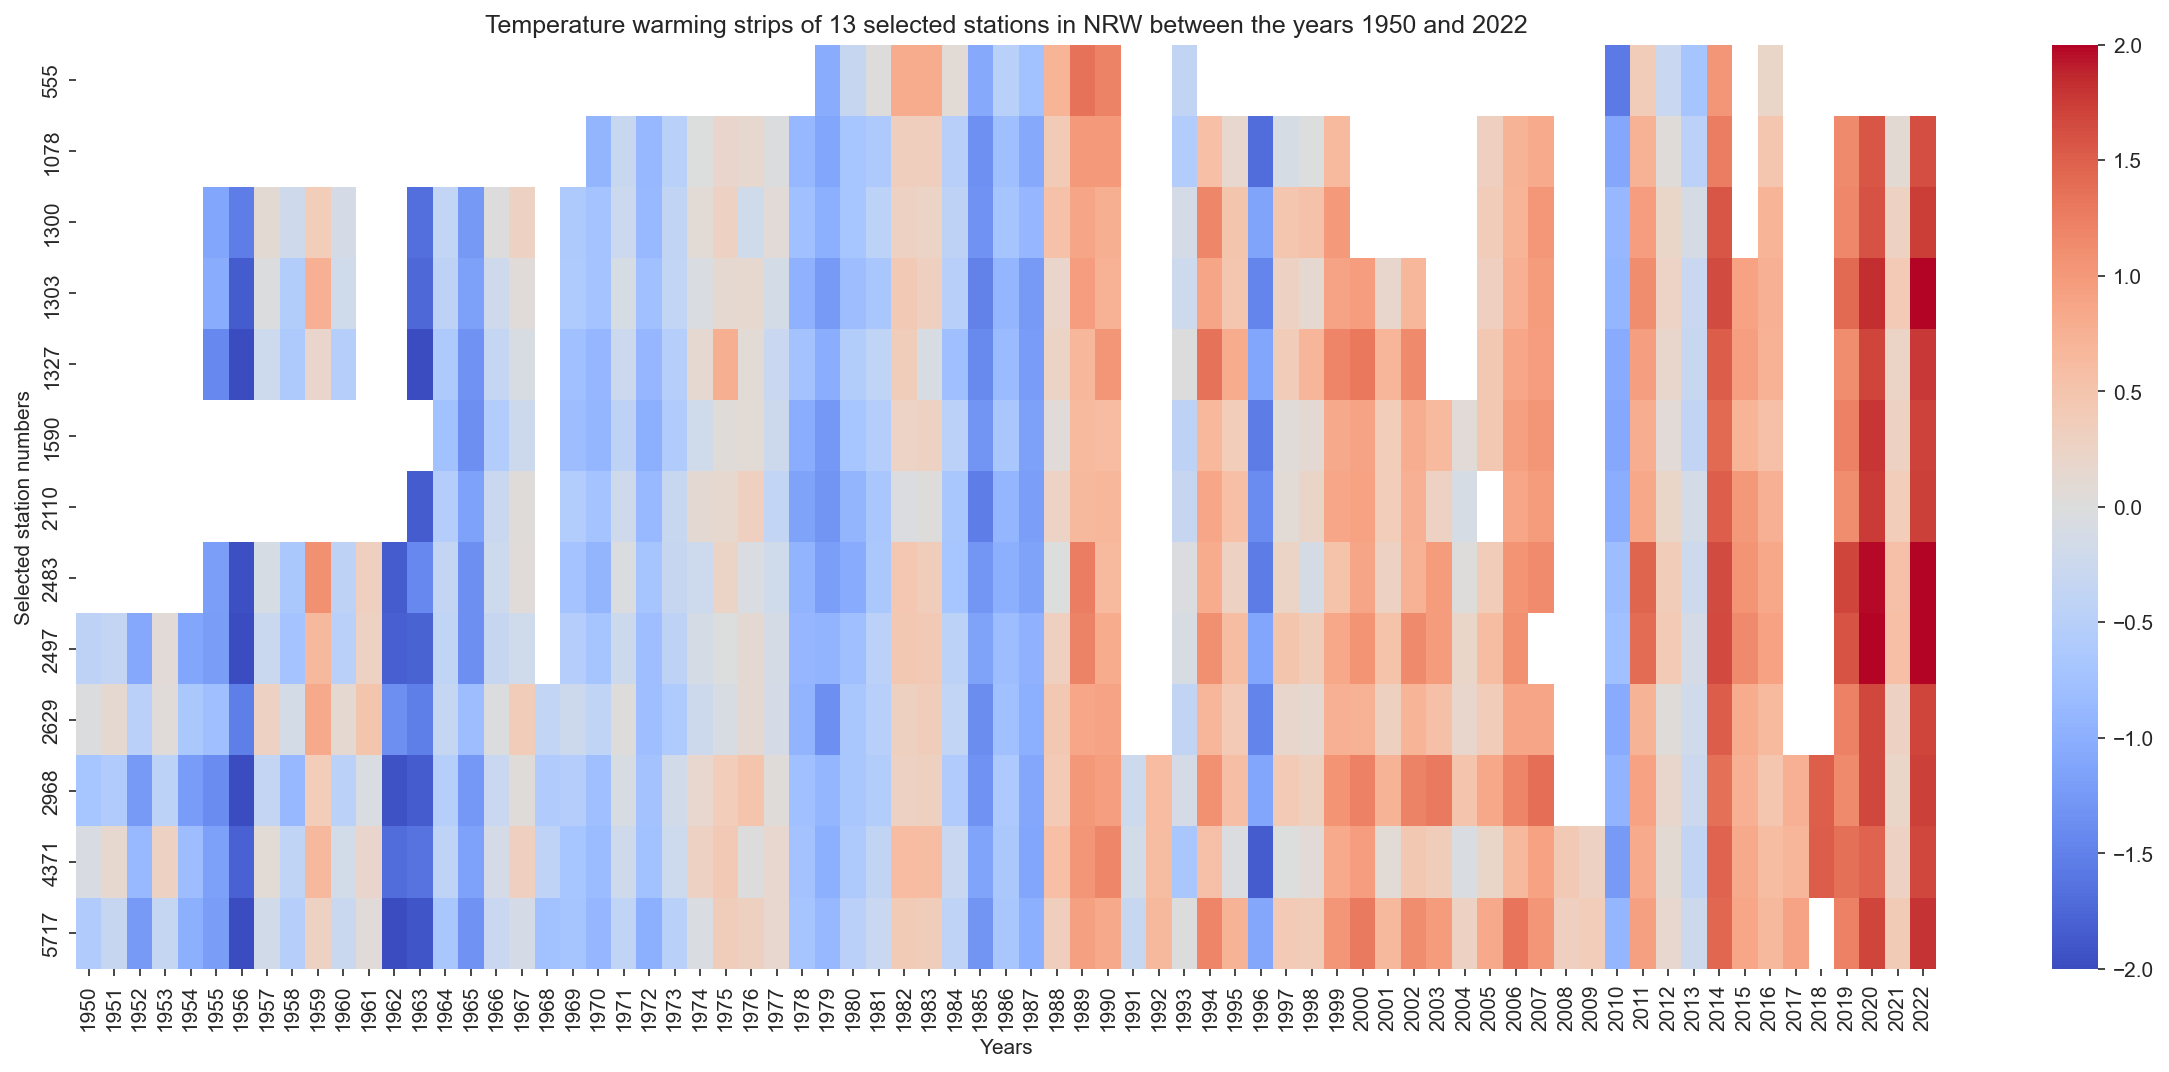

In [38]:
# plotting the temperature difference dataframe to generate the strips
sns.set_style('ticks')
fig3, ax3 = plt.subplots(dpi = 150, figsize = (20,8))
sns.heatmap(df_temp_diff[df_temp_diff.index >= 1950].T, cmap='coolwarm', vmin = -2, vmax = 2, ax = ax3)
fig3.savefig('Selected_Station_Temperature_warming_Strip.png')
plt.title("Temperature warming strips of 13 selected stations in NRW between the years 1950 and 2022")
plt.xlabel("Years")
plt.ylabel("Selected station numbers")